## SOYKOK Aylin 28711545
## CELIK Simay 28713301

### Some plots in the report are extracted from the textual outputs of these notebook and they do not appear in this.

<center><h1>Domain Adaptation</h1></center>

<center><h2><a href="https://arthurdouillard.com/deepcourse/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

We will implement the paper **Unsupervised Domain Adaptation by Backpropagation** in this session. We strongly advise to read this paper, it's a major one!

https://arxiv.org/abs/1409.7495

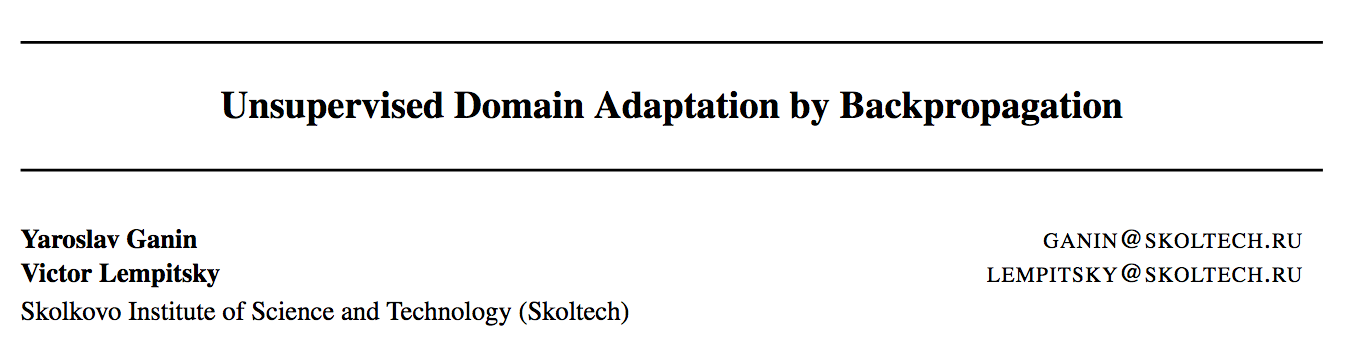

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
pip install torchvision

In [3]:
import pickle
import math

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image

In [4]:
import torchvision

In [5]:
print(torch.version.cuda)

12.1


We are going to do a **domain adaptation** from a source dataset (MNIST) towards a target dataset (MNIST-M).

First, we need to create the target dataset:

In [6]:
!wget https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py

--2024-12-22 10:29:37--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2918 (2.8K) [text/plain]
Saving to: ‘mnistm.py’

mnistm.py           100%[===================>]   2.85K  --.-KB/s    in 0s      

2024-12-22 10:29:37 (31.9 MB/s) - ‘mnistm.py’ saved [2918/2918]



In [7]:
from mnistm import create_mnistm
create_mnistm()

Creating MNIST-M... That may takes a minute
Loading BSR training images
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 351kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.16MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Building train set...
Processing example 0
Processing example 10000
Processing example 20000
Processing example 30000
Processing example 40000
Processing example 50000
Building test set...
Processing example 0
Done!


Then, let's load the MNIST dataset and compute its (train!) mean and standard deviation.

We will use those values to **standardize** both MNIST and MNIST-M.

In [8]:
mnist_pixels = torchvision.datasets.MNIST('.', train=True, download=True).data / 255
mean = mnist_pixels.mean().item()
std = mnist_pixels.std().item()

print(f"Mean {mean} and Std {std}")
mean = torch.tensor([mean, mean, mean])
std = torch.tensor([std, std, std])

Mean 0.13066047430038452 and Std 0.30810782313346863


Create the loaders for MNIST...

In [9]:
transform = transforms.Compose([
  transforms.ToTensor(),
  lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
  transforms.Normalize(mean, std)
])

mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

source_train_loader = DataLoader(mnist_train, batch_size=128)
source_test_loader = DataLoader(mnist_test, batch_size=128)

... and visualize!

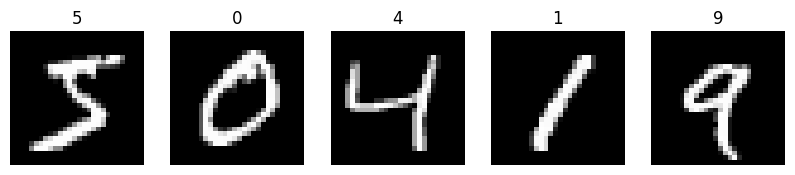

In [10]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnist_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
  plt.title(y)

Likewise, for MNIST-M. We create a simple `Dataset` in order to load the dataset that was serialized as a pickle:

In [11]:
with open('mnistm_data.pkl', 'rb') as f:
  mnist_m = pickle.load(f)

class MNISTM(torch.utils.data.Dataset):
  def __init__(self, x, y, transform):
    self.x, self.y = x, y
    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    x = self.transform(x)

    return x, y

mnistm_train = MNISTM(mnist_m["x_train"], mnist_m["y_train"], transform)
mnistm_test = MNISTM(mnist_m["x_test"], mnist_m["y_test"], transform)

target_train_loader = DataLoader(mnistm_train, batch_size=128)
target_test_loader = DataLoader(mnistm_test, batch_size=128)

And we also visualize it. Remember to always visualize your data before training a model on it. You may realize that the dataset is ill-formated, in its pixels or targets, and have to do more data preparation beforehand.

Noice that **MNIST-M** is extremely similar to MNIST. The only difference is that the former has colors and textures, and is thus a RGB image. Because MNIST is in grayscale, we have duplicated thrice its channels axis.

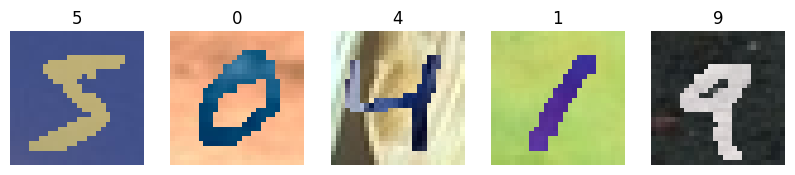

In [12]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnistm_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8))
  plt.title(y)

Now, let's implement this basic network, whose figure is extracted from the paper. Conceive your model so that convolutions do not reduce the spatial dimensions:

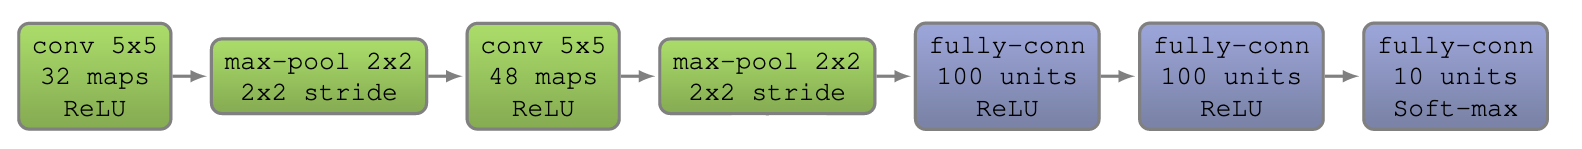

In [13]:
class NaiveNet(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
        nn.Conv2d(3, 32, (5,5), stride=1),
        nn.ReLU(),
        nn.MaxPool2d((2,2),stride=2, padding=0),
        nn.Conv2d(32, 48, (5,5), stride=1),
        nn.ReLU(),
        nn.MaxPool2d((2,2),stride=2, padding=0)
    )

    self.classif = self.classifier = nn.Sequential(
            nn.Linear(48 * 4 * 4, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10) #No softmax once again because it is included in CEL
    )

  def forward(self, x):
    # TODO
    x = self.cnn(x)
    x = x.view(x.size(0), -1)
    x = self.classif(x)
    return x


NaiveNet()(torch.randn(2, 3, 28, 28)).shape

torch.Size([2, 10])

In [14]:
def eval_model(net, loader):
  net.eval()

  acc, loss = 0, 0.
  c = 0
  for x, y in loader:
    c += len(x)

    with torch.no_grad():
      logits = net(x.cuda()).cpu()

    loss += F.cross_entropy(logits, y).item()
    acc += (logits.argmax(dim=1) == y).sum().item()

  return round(100 * acc / c, 2), round(loss / len(loader), 5)

Let's train our naive model, but only the source (MNIST) dataset. We will evaluate its performance on the target (MNIST-M) dataset afterwards.

Notice that we use a **learning rate scheduler**. We are updating the learning rate after each epoch according to a function defined with a *lambda* following the paper specification.

We set the initial learning rate to 1.0 because `LambdaLR` defines a *multiplicative factor* of the base learning rate.

It's often useful to reduce likewise the learning rate during training, to facilitate convergence once the model has found a good local minima (we rarely find the global).

In [21]:
epochs = 10

naive_net = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

for epoch in range(epochs):
  train_loss = 0.

  for x, y in source_train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = naive_net(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f'Epoch {epoch}, train loss: {round(train_loss / len(source_train_loader), 5)}')
  scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr']}")

test_acc, test_loss = eval_model(naive_net, source_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Epoch 0, train loss: 0.23628
	Learning rate = 0.005946035575013606
Epoch 1, train loss: 0.0433
	Learning rate = 0.004386913376508308
Epoch 2, train loss: 0.02877
	Learning rate = 0.0035355339059327372
Epoch 3, train loss: 0.0216
	Learning rate = 0.002990697562442441
Epoch 4, train loss: 0.017
	Learning rate = 0.0026084743001221454
Epoch 5, train loss: 0.01391
	Learning rate = 0.002323680802425408
Epoch 6, train loss: 0.01175
	Learning rate = 0.0021022410381342864
Epoch 7, train loss: 0.01007
	Learning rate = 0.0019245008972987524
Epoch 8, train loss: 0.00882
	Learning rate = 0.0017782794100389228
Epoch 9, train loss: 0.00779
	Learning rate = 0.0016556002607617019
Test loss: 0.02795, test acc: 99.11


Performance onn less than 10 epochs are great on MNIST, more than 99% accuracy! But this dataset is quite easy.

Now, the real question is: can our model generalize on the slightly different domain of MNIST-M?

In [22]:
test_acc, test_loss = eval_model(naive_net, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 1.34681, test acc: 56.34


No... You should have an accuracy of 53 to 57%, far less than the 99% we had.

We are going to implement **DANN**, the **Domain Adverserial Neural Network**. The key part of this network is its domain prediction branch and its **gradient reversal layer** (GRL).

The GRL will reverse the gradient between the domain classifier (in pink) and the features extractor (in green).

What does it mean intuitively? The gradient of the domain classifier should help to better classify the domain. Therefore if we reverse it before the end of the features extractor, we will force this CNN to do the opposite: to make the features as agnostic as possible from the domain. Which would mean that the features of MNIST and MNIST-M will be similar and only the digit info will be kept.

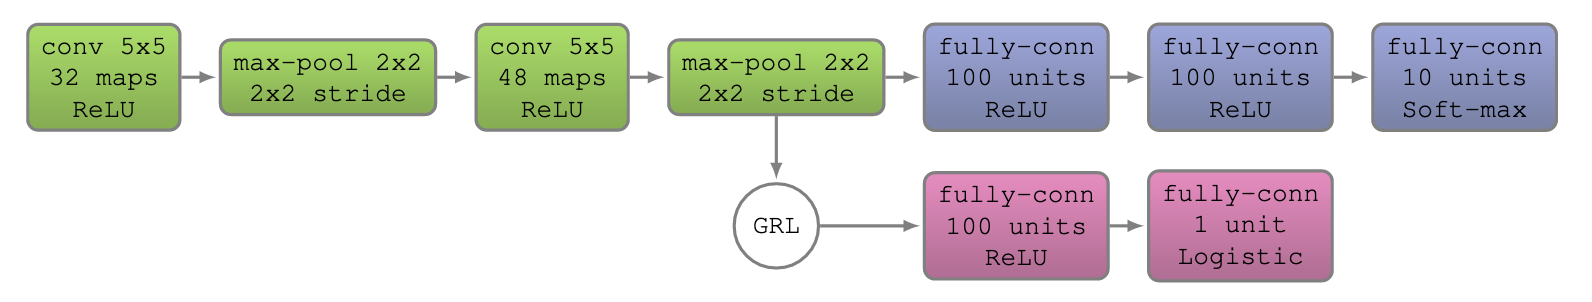

To code a custom backward in PyTorch, you need to define a `torch.autograd.Function`.

The forward is easy, we do nothing except storing a factor that we will need in the backward pass.

In the backward pass we need to return as much gradients as there are inputs (here two). Because the factor is not something to be optimized, we return `None`.

Now, given the factor (which is defaulted to -1, aka "reverse"), define the modified gradient:



In [15]:
class GradientReversal(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, factor=1):
    ctx.save_for_backward(torch.tensor(factor))
    return x

  @staticmethod
  def backward(ctx, grad):
    factor, = ctx.saved_tensors

    reversed_grad = -factor * grad

    return reversed_grad, None

In [16]:
x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = x * y
o.backward()
print(x.grad.item())

x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = GradientReversal.apply(x * y, -1)
o.backward()
print(x.grad.item())

1337.0
1337.0


To use a PyTorch's `Function`, call its apply

Now, code the DANN. You can re-use parts of the code you wrote for the naive model.

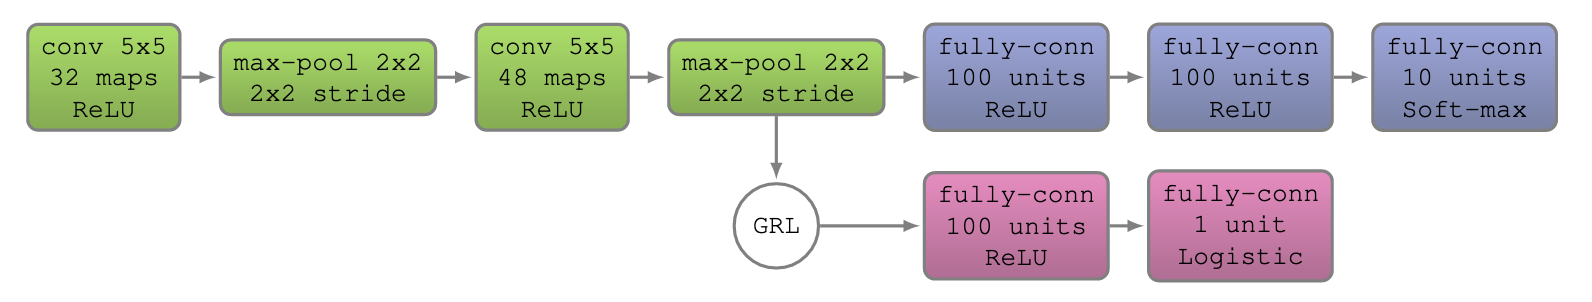

In [17]:
class DANN(nn.Module):
  def __init__(self):
    super().__init__()

    self.cnn = nn.Sequential(
        nn.Conv2d(3, 32, (5,5), stride=1),
        nn.ReLU(),
        nn.MaxPool2d((2,2),stride=2, padding=0),
        nn.Conv2d(32, 48, (5,5), stride=1),
        nn.ReLU(),
        nn.MaxPool2d((2,2),stride=2, padding=0)
    )

    self.classif = nn.Sequential(
            nn.Linear(48 * 4 * 4, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10) #No softmax once again because it is included in CEL
    )

    self.domain = nn.Sequential(
            nn.Linear(48 * 4 * 4, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
    )

  def forward(self, x, factor=1):
    # TODO
    x = self.cnn(x)
    x = x.view(x.size(0), -1)
    class_pred = self.classif(x)

    domain_pred = self.domain(GradientReversal.apply(x,factor))

    return class_pred, domain_pred


In [18]:
def eval_dann(net, loader, source=True):
  net.eval()

  c_acc, d_acc, cls_loss, d_loss = 0, 0, 0., 0.
  c = 0
  for x, y in loader:
    x = x.cuda()
    if source:
      d = torch.ones(len(x))
    else:
      d = torch.zeros(len(x))

    c += len(x)

    with torch.no_grad():
      cls_logits, domain_logits = net(x.cuda())
      cls_logits, domain_logits = cls_logits.cpu(), domain_logits.cpu()

    cls_loss += F.cross_entropy(cls_logits, y).item()
    d_loss += F.binary_cross_entropy_with_logits(domain_logits[:, 0], d).item()

    c_acc += (cls_logits.argmax(dim=1) == y).sum().item()
    d_acc += ((torch.sigmoid(domain_logits[:, 0]) > 0.5).float() == d).sum().item()

  return round(100 * c_acc / c, 2), round(100 * d_acc / c, 2), round(cls_loss / len(loader), 5), round(d_loss / len(loader), 5)

In [19]:
source_train_loader = DataLoader(mnist_train, batch_size=64)
target_train_loader = DataLoader(mnistm_train, batch_size=64)

len(source_train_loader), len(target_train_loader)

(938, 938)

For the GRL, using directly a factor -1 will results in very bad performance. Therefore we are going to grow the factor gradually during training (deep learning is an art!).

Here is a plot of the function we will use (note that it is a modified version from the paper):

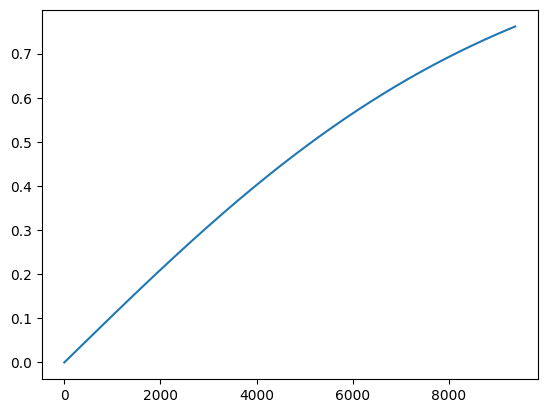

In [23]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / nb_iters))
y = [lmbd(i) for i in x]

plt.plot(x, y)


Let's train our DANN. The GRL factor will be updated after each batch.

Remember that we are not allowed to use the labels of MNIST-M as we assume this dataset is **unlabeled**.

In [ ]:
epochs = 20

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0
cls_losses, domain_losses = [], []
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    ce = F.cross_entropy(cls_logits[:len(xs)], ys)
    bce = F.binary_cross_entropy_with_logits(domain_logits[:, 0], torch.cat((torch.ones(len(xs)), torch.zeros(len(xt)))).cuda())
    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()
  cls_losses.append(cls_loss)
  domain_losses.append(domain_loss)

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0.0
Epoch 0, class loss: 0.2403, domain loss: 0.10829
GRL factor 0.049958374957880025
Epoch 1, class loss: 0.04957, domain loss: 0.09221
GRL factor 0.0996679946249559
Epoch 2, class loss: 0.03457, domain loss: 0.10893
GRL factor 0.14888503362331806
Epoch 3, class loss: 0.02763, domain loss: 0.11066
GRL factor 0.197375320224904
Epoch 4, class loss: 0.02827, domain loss: 0.13841
GRL factor 0.2449186624037092
Epoch 5, class loss: 0.03696, domain loss: 0.17474
GRL factor 0.2913126124515908
Epoch 6, class loss: 0.04987, domain loss: 0.19717
GRL factor 0.3363755443363323
Epoch 7, class loss: 0.05303, domain loss: 0.23752
GRL factor 0.379948962255225
Epoch 8, class loss: 0.05844, domain loss: 0.2625
GRL factor 0.4218990052500078
Epoch 9, class loss: 0.05374, domain loss: 0.27493
GRL factor 0.4621171572600098
Epoch 10, class loss: 0.05871, domain loss: 0.26366
GRL factor 0.5005202111902354
Epoch 11, class loss: 0.04166, domain loss: 0.27083
GRL factor 0.5370495669980351
Epoch 12, cl

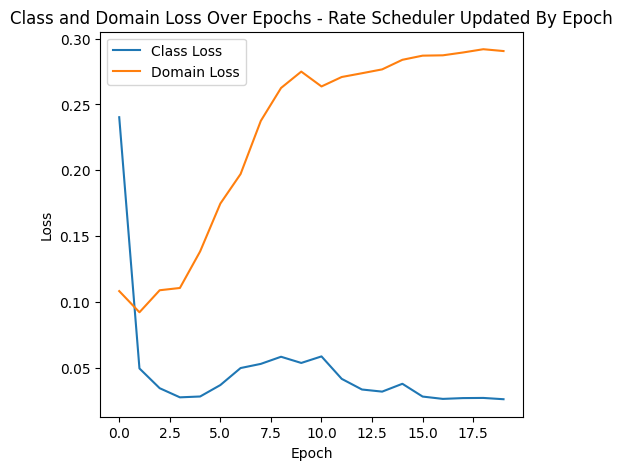

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), cls_losses, label='Class Loss')
plt.plot(range(epochs), domain_losses, label='Domain Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Class and Domain Loss Over Epochs - Rate Scheduler Updated By Epoch')
plt.legend()

We should see a huge gain, from the ~55% of accuracy on MNIST-M to more than 73% of accuracy without ever seeing labels of MNIST-M.

This is a very nice gain. Let's now verify visualy that our features space is indeed agnostic to the domain:

In [ ]:
def extract_emb(net, loader):
  embeddings = []

  for x, _ in loader:
    with torch.no_grad():
      feats = net.cnn(x.cuda()).view(len(x), -1).cpu()

    embeddings.append(feats.numpy())

  return np.concatenate(embeddings)

We use **TSNE** to visualize the embeddings. As you can guess, a human cannot comprehend a space of hundred of dimensions, thus TSNE can project this space onto a space of 2 dimensions.

But beware of the several drawbacks of TSNE:
- **it is super slow**, so we will compute it on a subset of the data
- **it is not determinist**, so you can have different results everytime
- **it can be tuned**, and as everything that can be tuned, you can "*force*" it to take some aspect that you wish it has, while not being really representative of the real data

If you want to learn more about TSNE, head off to this fantastic website: https://distill.pub/2016/misread-tsne/

In [ ]:
from sklearn.manifold import TSNE

Original embeddings of source / target (60000, 768) (60000, 768)
Samples embeddings (2000, 768) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'Without domain adaptation')

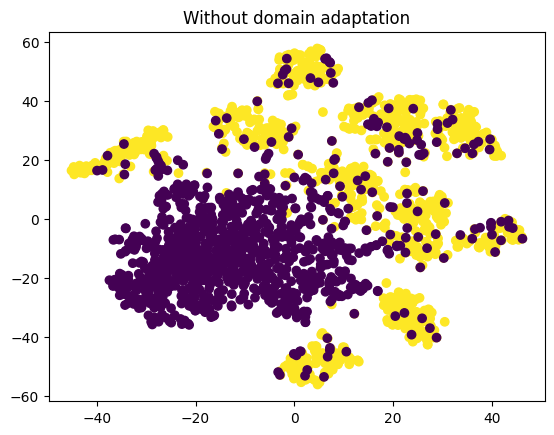

In [ ]:
source_emb = extract_emb(naive_net, source_train_loader)
target_emb = extract_emb(naive_net, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("Without domain adaptation")

Yellow dots are the source (MNIST) dataset, while purple dots are the target dataset (MNIST-M). We can clearly see that they belong to different space if we use the naive model.

Original embeddings of source / target (60000, 768) (60000, 768)
Samples embeddings (2000, 768) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

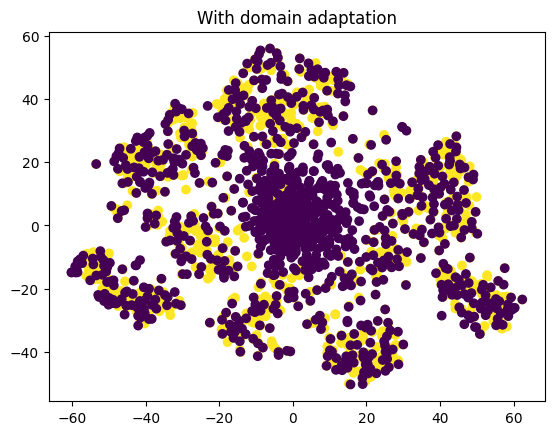

In [ ]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

But with our DANN, while still imperfect, the two domains are much more merged. This confirm our intuition that the GRL forces the network to produce domain-agnostic features.

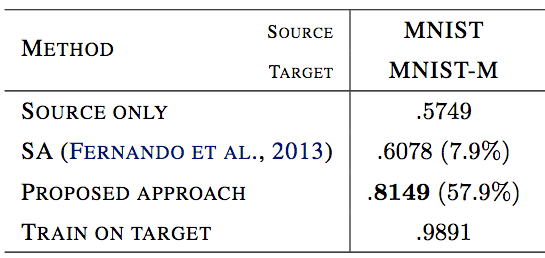

Our model is still lower than the performance reported in the original paper. You can try to further improve it by:

- use much more epochs
- modify the learning rate scheduler to be updated per step
- test different standardization
- different GRL factor scheduling

## Increasing the number of epochs

# DO NOT RERUN
.

.

.

.

.

.

.

# DO NOT RERUN

Number of epochs = 50
GRL factor 0.0
Epoch 0, class loss: 0.23252, domain loss: 0.10511
GRL factor 0.01999733375993107
Epoch 1, class loss: 0.05018, domain loss: 0.06938
GRL factor 0.039978680311163695
Epoch 2, class loss: 0.03062, domain loss: 0.06314
GRL factor 0.05992810352914346
Epoch 3, class loss: 0.02199, domain loss: 0.07221
GRL factor 0.07982976911113138
Epoch 4, class loss: 0.01764, domain loss: 0.07838
GRL factor 0.0996679946249559
Epoch 5, class loss: 0.01442, domain loss: 0.07911
GRL factor 0.11942729853438583
Epoch 6, class loss: 0.01237, domain loss: 0.08847
GRL factor 0.1390924478784581
Epoch 7, class loss: 0.01238, domain loss: 0.10545
GRL factor 0.158648504297499
Epoch 8, class loss: 0.01694, domain loss: 0.13359
GRL factor 0.17808086811733026
Epoch 9, class loss: 0.0244, domain loss: 0.16861
GRL factor 0.197375320224904
Epoch 10, class loss: 0.02679, domain loss: 0.18366
GRL factor 0.21651806149302866
Epoch 11, class loss: 0.02805, domain loss: 0.20031
GRL factor 0.2

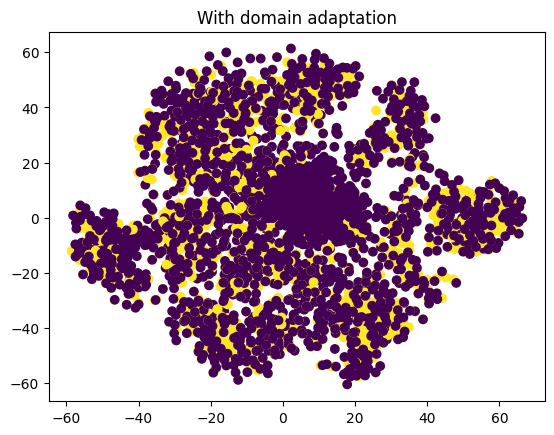

In [ ]:
epochs_list = [50,100]

for epochs in epochs_list:
  print("Number of epochs =",epochs)
  dann = DANN().cuda()

  optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

  mu0, alpha, beta = 0.01, 10, 0.75
  scheduler = torch.optim.lr_scheduler.LambdaLR(
      optimizer,
      lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
  )
  lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

  b = 0
  for epoch in range(epochs):
    cls_loss, domain_loss = 0., 0.
    grl_factor = lmbd(b)
    print(f"GRL factor {grl_factor}" )

    for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
      grl_factor = lmbd(b)
      b += 1

      xs, ys = xs.cuda(), ys.cuda()
      xt = xt.cuda()
      x = torch.cat((xs, xt))

      optimizer.zero_grad()
      cls_logits, domain_logits = dann(x, factor=grl_factor)

      ce = F.cross_entropy(cls_logits[:len(xs)], ys)
      bce = F.binary_cross_entropy_with_logits(domain_logits[:, 0], torch.cat((torch.ones(len(xs)), torch.zeros(len(xt)))).cuda())
      loss = ce + bce
      loss.backward()
      optimizer.step()

      cls_loss += ce.item()
      domain_loss += bce.item()

    cls_loss = round(cls_loss / len(source_train_loader), 5)
    domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
    print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
    scheduler.step()

  c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
  print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

  c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
  print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

  source_emb = extract_emb(dann, source_train_loader)
  target_emb = extract_emb(dann, target_train_loader)

  print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

  indexes = np.random.permutation(len(source_emb))[:1000]

  emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
  domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

  print("Samples embeddings", emb.shape, domains.shape)

  tsne = TSNE(n_components=2)

  emb_2d = tsne.fit_transform(emb)
  print("Dimension reduced embeddings", emb_2d.shape)

  plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
  plt.title("With domain adaptation")

## modify the learning rate scheduler to be updated per step

In [24]:
epochs = 20

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
total_steps = len(source_train_loader) * epochs

#modified it to total steps
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda step: mu0 / (1 + alpha * step / total_steps) ** beta
)
lmbd = lambda b: -1 + 2 / (1 + math.exp(-2 * b / total_steps))

b = 0

cls_losses, domain_losses = [], []

for epoch in range(epochs):
    cls_loss, domain_loss = 0., 0.

    for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
        grl_factor = lmbd(b)
        b += 1

        xs, ys = xs.cuda(), ys.cuda()
        xt = xt.cuda()
        x = torch.cat((xs, xt))

        optimizer.zero_grad()
        cls_logits, domain_logits = dann(x, factor=grl_factor)

        ce = F.cross_entropy(cls_logits[:len(xs)], ys)
        bce = F.binary_cross_entropy_with_logits(
            domain_logits[:, 0],
            torch.cat((torch.ones(len(xs)), torch.zeros(len(xt)))).cuda()
        )
        loss = ce + bce
        loss.backward()
        optimizer.step()

        scheduler.step()

        cls_loss += ce.item()
        domain_loss += bce.item()

    cls_loss = round(cls_loss / len(source_train_loader), 5)
    domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
    print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
    cls_losses.append(cls_loss)
    domain_losses.append(domain_loss)

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")


Epoch 0, class loss: 0.24861, domain loss: 0.11457
Epoch 1, class loss: 0.05379, domain loss: 0.11427
Epoch 2, class loss: 0.03637, domain loss: 0.10805
Epoch 3, class loss: 0.02875, domain loss: 0.11153
Epoch 4, class loss: 0.02826, domain loss: 0.13411
Epoch 5, class loss: 0.03431, domain loss: 0.16274
Epoch 6, class loss: 0.04625, domain loss: 0.2081
Epoch 7, class loss: 0.06285, domain loss: 0.27562
Epoch 8, class loss: 0.06085, domain loss: 0.28685
Epoch 9, class loss: 0.04721, domain loss: 0.29797
Epoch 10, class loss: 0.0346, domain loss: 0.28522
Epoch 11, class loss: 0.02845, domain loss: 0.2785
Epoch 12, class loss: 0.02824, domain loss: 0.28044
Epoch 13, class loss: 0.02775, domain loss: 0.28526
Epoch 14, class loss: 0.02708, domain loss: 0.28805
Epoch 15, class loss: 0.02739, domain loss: 0.29138
Epoch 16, class loss: 0.02683, domain loss: 0.29307
Epoch 17, class loss: 0.02523, domain loss: 0.29336
Epoch 18, class loss: 0.03418, domain loss: 0.30309
Epoch 19, class loss: 0.0

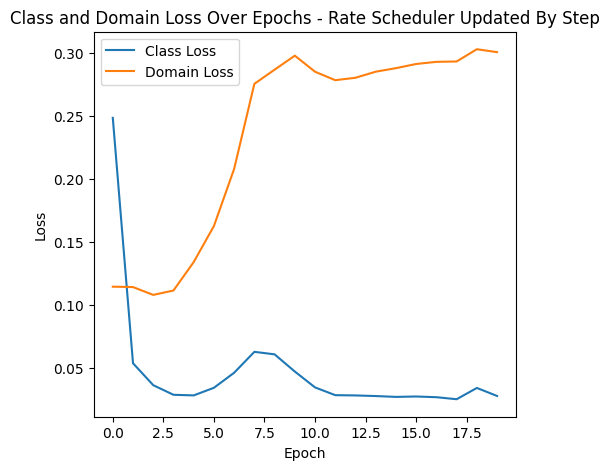

In [25]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), cls_losses, label='Class Loss')
plt.plot(range(epochs), domain_losses, label='Domain Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Class and Domain Loss Over Epochs - Rate Scheduler Updated By Step')
plt.legend()

## testing different standardizations



In [ ]:
# standardizations = [
#     ("Standard Normalization",transforms.Compose([
#         transforms.ToTensor(),
#         lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
#         transforms.Normalize((0.5,), (0.5,))  #standard norm
#     ])),
#     ("No Normalization",transforms.Compose([
#         transforms.ToTensor(),
#         lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x, #no norm
#     ])),
#     ("ImageNet Normalization",transforms.Compose([
#         transforms.ToTensor(),
#         lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x, #imagenet norm
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ]))
# ]

standardizations = [("Standard Normalization",(0.5,),(0.5,)),("ImageNet Normalization",[0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
                    ("Random Normalization",(0.140,0.324,0.943),(0.434,0.431,0.1))]

Standardization :  Standard Normalization


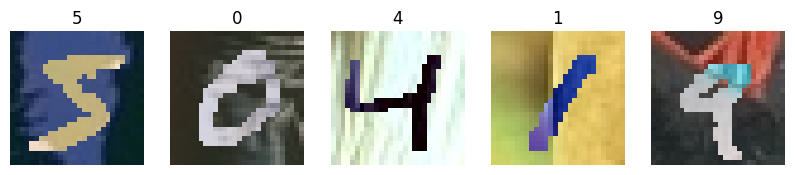

GRL factor 0.0
Epoch 0, class loss: 0.19641, domain loss: 0.02927
GRL factor 0.024994792968420665
Epoch 1, class loss: 0.03433, domain loss: 0.00933
GRL factor 0.049958374957880025
Epoch 2, class loss: 0.02139, domain loss: 0.00514
GRL factor 0.0748596906874992
Epoch 3, class loss: 0.01461, domain loss: 0.00346
GRL factor 0.0996679946249559
Epoch 4, class loss: 0.01059, domain loss: 0.00473
GRL factor 0.12435300177159614
Epoch 5, class loss: 0.00805, domain loss: 0.00438
GRL factor 0.14888503362331806
Epoch 6, class loss: 0.00625, domain loss: 0.00667
GRL factor 0.17323515783466026
Epoch 7, class loss: 0.00509, domain loss: 0.00916
GRL factor 0.197375320224904
Epoch 8, class loss: 0.00471, domain loss: 0.01507
GRL factor 0.22127846789844408
Epoch 9, class loss: 0.00418, domain loss: 0.00139
GRL factor 0.2449186624037092
Epoch 10, class loss: 0.00302, domain loss: 0.00119
GRL factor 0.2682711820216015
Epoch 11, class loss: 0.00658, domain loss: 0.0132
GRL factor 0.2913126124515908
Epoch

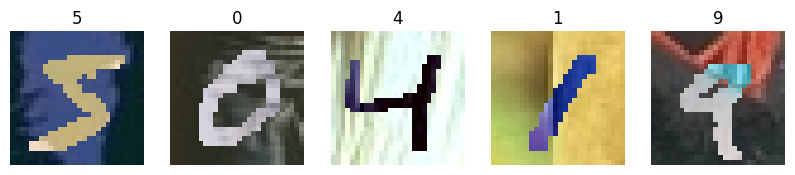

GRL factor 0.0
Epoch 0, class loss: 0.20244, domain loss: 0.07737
GRL factor 0.024994792968420665
Epoch 1, class loss: 0.03595, domain loss: 0.06674
GRL factor 0.049958374957880025
Epoch 2, class loss: 0.02382, domain loss: 0.07311
GRL factor 0.0748596906874992
Epoch 3, class loss: 0.01632, domain loss: 0.07393
GRL factor 0.0996679946249559
Epoch 4, class loss: 0.01143, domain loss: 0.07354
GRL factor 0.12435300177159614
Epoch 5, class loss: 0.00928, domain loss: 0.0764
GRL factor 0.14888503362331806
Epoch 6, class loss: 0.00785, domain loss: 0.0821
GRL factor 0.17323515783466026
Epoch 7, class loss: 0.0069, domain loss: 0.08638
GRL factor 0.197375320224904
Epoch 8, class loss: 0.00657, domain loss: 0.0906
GRL factor 0.22127846789844408
Epoch 9, class loss: 0.00653, domain loss: 0.09674
GRL factor 0.2449186624037092
Epoch 10, class loss: 0.0072, domain loss: 0.105
GRL factor 0.2682711820216015
Epoch 11, class loss: 0.00759, domain loss: 0.10803
GRL factor 0.2913126124515908
Epoch 12, c

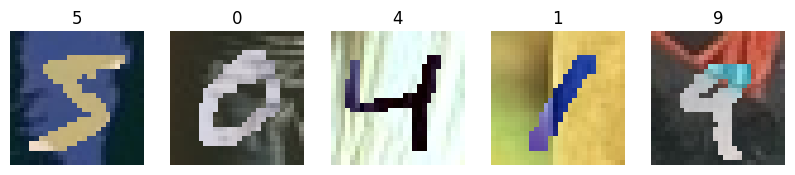

GRL factor 0.0
Epoch 0, class loss: 0.19486, domain loss: 0.01297
GRL factor 0.024994792968420665
Epoch 1, class loss: 0.0359, domain loss: 0.01617
GRL factor 0.049958374957880025
Epoch 2, class loss: 0.0241, domain loss: 0.06782
GRL factor 0.0748596906874992
Epoch 3, class loss: 0.01625, domain loss: 0.00013
GRL factor 0.0996679946249559
Epoch 4, class loss: 0.01381, domain loss: 0.02878
GRL factor 0.12435300177159614
Epoch 5, class loss: 0.01609, domain loss: 0.02402
GRL factor 0.14888503362331806
Epoch 6, class loss: 0.00913, domain loss: 0.00325
GRL factor 0.17323515783466026
Epoch 7, class loss: 0.01205, domain loss: 0.01334
GRL factor 0.197375320224904
Epoch 8, class loss: 0.00596, domain loss: 2e-05
GRL factor 0.22127846789844408
Epoch 9, class loss: 0.0042, domain loss: 1e-05
GRL factor 0.2449186624037092
Epoch 10, class loss: 0.00306, domain loss: 0.0
GRL factor 0.2682711820216015
Epoch 11, class loss: 0.00228, domain loss: 0.0
GRL factor 0.2913126124515908
Epoch 12, class los

In [ ]:
for name,mean,std in standardizations :
  print('Standardization : ',name)
  transform = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
        transforms.Normalize(mean, std)
    ])
  mnistm_train = MNISTM(mnist_m["x_train"], mnist_m["y_train"], transform)
  mnistm_test = MNISTM(mnist_m["x_test"], mnist_m["y_test"], transform)

  target_train_loader = DataLoader(mnistm_train, batch_size=128)
  target_test_loader = DataLoader(mnistm_test, batch_size=128)

  plt.figure(figsize=(10, 7))
  mean = torch.tensor(mean)
  std = torch.tensor(std)

  for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    ax.axis('off')
    x, y = mnistm_train[i]
    img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
    plt.imshow(img.numpy().astype(np.uint8))
    plt.title(y)

  plt.show()


  epochs = 20

  dann = DANN().cuda()

  optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

  mu0, alpha, beta = 0.01, 10, 0.75
  scheduler = torch.optim.lr_scheduler.LambdaLR(
      optimizer,
      lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
  )
  lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

  b = 0
  cls_losses, domain_losses = [], []
  for epoch in range(epochs):
    cls_loss, domain_loss = 0., 0.
    grl_factor = lmbd(b)
    print(f"GRL factor {grl_factor}" )

    for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
      grl_factor = lmbd(b)
      b += 1

      xs, ys = xs.cuda(), ys.cuda()
      xt = xt.cuda()
      x = torch.cat((xs, xt))

      optimizer.zero_grad()
      cls_logits, domain_logits = dann(x, factor=grl_factor)

      ce = F.cross_entropy(cls_logits[:len(xs)], ys)
      bce = F.binary_cross_entropy_with_logits(domain_logits[:, 0], torch.cat((torch.ones(len(xs)), torch.zeros(len(xt)))).cuda())
      loss = ce + bce
      loss.backward()
      optimizer.step()

      cls_loss += ce.item()
      domain_loss += bce.item()

    cls_loss = round(cls_loss / len(source_train_loader), 5)
    domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
    print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
    scheduler.step()
    cls_losses.append(cls_loss)
    domain_losses.append(domain_loss)

  c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
  print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

  c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
  print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")


## different GRL factor scheduling

In [ ]:
#try different lmdb() ??
transform = transforms.Compose([
  transforms.ToTensor(),
  lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
  transforms.Normalize(mean, std)
])

mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

source_train_loader = DataLoader(mnist_train, batch_size=128)
source_test_loader = DataLoader(mnist_test, batch_size=128)

mnistm_train = MNISTM(mnist_m["x_train"], mnist_m["y_train"], transform)
mnistm_test = MNISTM(mnist_m["x_test"], mnist_m["y_test"], transform)

target_train_loader = DataLoader(mnistm_train, batch_size=128)
target_test_loader = DataLoader(mnistm_test, batch_size=128)

In [ ]:
def main(lmbd):
  epochs = 20

  dann = DANN().cuda()

  optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

  mu0, alpha, beta = 0.01, 10, 0.75
  scheduler = torch.optim.lr_scheduler.LambdaLR(
      optimizer,
      lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
  )
  lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

  b = 0
  cls_losses, domain_losses = [], []
  for epoch in range(epochs):
    cls_loss, domain_loss = 0., 0.
    grl_factor = lmbd(b)
    print(f"GRL factor {grl_factor}" )

    for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
      grl_factor = lmbd(b)
      b += 1

      xs, ys = xs.cuda(), ys.cuda()
      xt = xt.cuda()
      x = torch.cat((xs, xt))

      optimizer.zero_grad()
      cls_logits, domain_logits = dann(x, factor=grl_factor)

      ce = F.cross_entropy(cls_logits[:len(xs)], ys)
      bce = F.binary_cross_entropy_with_logits(domain_logits[:, 0], torch.cat((torch.ones(len(xs)), torch.zeros(len(xt)))).cuda())
      loss = ce + bce
      loss.backward()
      optimizer.step()

      cls_loss += ce.item()
      domain_loss += bce.item()

    cls_loss = round(cls_loss / len(source_train_loader), 5)
    domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
    print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
    scheduler.step()
    cls_losses.append(cls_loss)
    domain_losses.append(domain_loss)

  c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
  print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

  c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
  print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")


In [ ]:
print("Linear Decay")
lmbd_linear = lambda e: 1.0 - (1.0 - 0.0) * (e / epochs)
main(lmbd_linear)

Linear Decay
GRL factor 0.0
Epoch 0, class loss: 0.19791, domain loss: 0.00454
GRL factor 0.024994792968420665
Epoch 1, class loss: 0.03767, domain loss: 0.01017
GRL factor 0.049958374957880025
Epoch 2, class loss: 0.02475, domain loss: 0.04761
GRL factor 0.0748596906874992
Epoch 3, class loss: 0.01838, domain loss: 0.01825
GRL factor 0.0996679946249559
Epoch 4, class loss: 0.01243, domain loss: 0.017
GRL factor 0.12435300177159614
Epoch 5, class loss: 0.00958, domain loss: 0.0
GRL factor 0.14888503362331806
Epoch 6, class loss: 0.00686, domain loss: 1e-05
GRL factor 0.17323515783466026
Epoch 7, class loss: 0.00509, domain loss: 1e-05
GRL factor 0.197375320224904
Epoch 8, class loss: 0.00385, domain loss: 3e-05
GRL factor 0.22127846789844408
Epoch 9, class loss: 0.02249, domain loss: 0.02712
GRL factor 0.2449186624037092
Epoch 10, class loss: nan, domain loss: nan
GRL factor 0.2682711820216015
Epoch 11, class loss: nan, domain loss: nan
GRL factor 0.2913126124515908
Epoch 12, class los

In [ ]:
print("Cosine Decay")
lmbd_cos = lambda e: 0.0 + (1.0 - 0.0) * (1 + math.cos(math.pi * e / epochs)) / 2
main(lmbd_cos)

Cosine Decay
GRL factor 0.0
Epoch 0, class loss: 0.29292, domain loss: 0.1943
GRL factor 0.049958374957880025
Epoch 1, class loss: 0.05424, domain loss: 0.12066
GRL factor 0.0996679946249559
Epoch 2, class loss: 0.03841, domain loss: 0.10859
GRL factor 0.14888503362331806
Epoch 3, class loss: 0.03138, domain loss: 0.11394
GRL factor 0.197375320224904
Epoch 4, class loss: 0.03319, domain loss: 0.14621
GRL factor 0.2449186624037092
Epoch 5, class loss: 0.03755, domain loss: 0.17753
GRL factor 0.2913126124515908
Epoch 6, class loss: 0.04214, domain loss: 0.20218
GRL factor 0.3363755443363323
Epoch 7, class loss: 0.05824, domain loss: 0.25013
GRL factor 0.379948962255225
Epoch 8, class loss: 0.0623, domain loss: 0.28906
GRL factor 0.4218990052500078
Epoch 9, class loss: 0.07843, domain loss: 0.35534
GRL factor 0.4621171572600098
Epoch 10, class loss: 0.07531, domain loss: 0.3457
GRL factor 0.5005202111902354
Epoch 11, class loss: 0.06333, domain loss: 0.31783
GRL factor 0.5370495669980351


## trying different negative numbers

In [1]:
for multiplier in [2,3,4,5]:
  epochs = 20
  
  dann = DANN().cuda()

  optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

  mu0, alpha, beta = 0.01, 10, 0.75
  scheduler = torch.optim.lr_scheduler.LambdaLR(
      optimizer,
      lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
  )
  lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))
  print("Negative number = ",b)
  cls_losses, domain_losses = [], []
  b=0
  for epoch in range(epochs):
    cls_loss, domain_loss = 0., 0.
    grl_factor = lmbd(b)
    print(f"GRL factor {grl_factor}" )

    for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
      b += 1
      grl_factor = lmbd(b)
      xs, ys = xs.cuda(), ys.cuda()
      xt = xt.cuda()
      x = torch.cat((xs, xt))

      optimizer.zero_grad()
      cls_logits, domain_logits = dann(x, factor=multiplier*grl_factor)

      ce = F.cross_entropy(cls_logits[:len(xs)], ys)
      bce = F.binary_cross_entropy_with_logits(domain_logits[:, 0], torch.cat((torch.ones(len(xs)), torch.zeros(len(xt)))).cuda())
      loss = ce + bce
      loss.backward()
      optimizer.step()

      cls_loss += ce.item()
      domain_loss += bce.item()

    cls_loss = round(cls_loss / len(source_train_loader), 5)
    domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
    print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
    scheduler.step()
    cls_losses.append(cls_loss)
    domain_losses.append(domain_loss)

  c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
  print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

  c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
  print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(range(epochs), cls_losses, label='Class Loss')
  plt.plot(range(epochs), domain_losses, label='Domain Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Class and Domain Loss Over Epochs - Negative Value = '+str(-multiplier*grl_factor))
  plt.legend()



## RESULTS 
Multiplier = 2 

RL factor 0.0
Epoch 0, class loss: 0.25128, domain loss: 0.12563
GRL factor 0.049958374957880025
Epoch 1, class loss: 0.05061, domain loss: 0.12133
GRL factor 0.0996679946249559
Epoch 2, class loss: 0.04408, domain loss: 0.14815
GRL factor 0.14888503362331806
Epoch 3, class loss: 0.0581, domain loss: 0.19251
GRL factor 0.197375320224904
Epoch 4, class loss: 0.08651, domain loss: 0.23618
GRL factor 0.2449186624037092
Epoch 5, class loss: 0.07442, domain loss: 0.2659
GRL factor 0.2913126124515908
Epoch 6, class loss: 0.09783, domain loss: 0.29541
GRL factor 0.3363755443363323
Epoch 7, class loss: 0.0463, domain loss: 0.30035
GRL factor 0.379948962255225
Epoch 8, class loss: 0.03793, domain loss: 0.2955
GRL factor 0.4218990052500078
Epoch 9, class loss: 0.03718, domain loss: 0.30616
GRL factor 0.4621171572600098
Epoch 10, class loss: 0.07357, domain loss: 0.3217
GRL factor 0.5005202111902354
Epoch 11, class loss: 0.04725, domain loss: 0.31325
GRL factor 0.5370495669980351
Epoch 12, class loss: 0.04258, domain loss: 0.32528
GRL factor 0.5716699660851172
Epoch 13, class loss: 0.04535, domain loss: 0.32288
GRL factor 0.6043677771171634
Epoch 14, class loss: 0.04198, domain loss: 0.32582
GRL factor 0.6351489523872873
Epoch 15, class loss: 0.03996, domain loss: 0.32655
GRL factor 0.6640367702678489
Epoch 16, class loss: 0.03966, domain loss: 0.3276
GRL factor 0.6910694698329305
Epoch 17, class loss: 0.03622, domain loss: 0.32725
GRL factor 0.7162978701990246
Epoch 18, class loss: 0.03369, domain loss: 0.3298
GRL factor 0.7397830512740042
Epoch 19, class loss: 0.03427, domain loss: 0.33023
[SOURCE] Class loss/acc: 0.05595 / 98.18%, Domain loss/acc: 0.67737 / 66.48%
[TARGET] Class loss/acc: 1.47031 / 70.81%, Domain loss/acc: 0.66093 / 56.91%


Multiplier = 3

Negative number =  18760
GRL factor 0.0
Epoch 0, class loss: 0.26096, domain loss: 0.14205
GRL factor 0.049958374957880025
Epoch 1, class loss: 0.06072, domain loss: 0.13875
GRL factor 0.0996679946249559
Epoch 2, class loss: 0.62114, domain loss: 0.19269
GRL factor 0.14888503362331806
Epoch 3, class loss: 0.29725, domain loss: 0.02854
GRL factor 0.197375320224904
Epoch 4, class loss: 0.10625, domain loss: 0.02568
GRL factor 0.2449186624037092
Epoch 5, class loss: 0.08423, domain loss: 0.03856
GRL factor 0.2913126124515908
Epoch 6, class loss: 0.1954, domain loss: 0.14719
GRL factor 0.3363755443363323
Epoch 7, class loss: 0.22903, domain loss: 0.29434
GRL factor 0.379948962255225
Epoch 8, class loss: 0.1839, domain loss: 0.28959
GRL factor 0.4218990052500078
Epoch 9, class loss: 0.15809, domain loss: 0.26001
GRL factor 0.4621171572600098
Epoch 10, class loss: 0.70751, domain loss: 0.29601
GRL factor 0.5005202111902354
Epoch 11, class loss: 2.16113, domain loss: 0.21857
GRL factor 0.5370495669980351
Epoch 12, class loss: 0.41687, domain loss: 0.10901
GRL factor 0.5716699660851172
Epoch 13, class loss: 0.20357, domain loss: 0.10484
GRL factor 0.6043677771171634
Epoch 14, class loss: 0.16318, domain loss: 0.11137
GRL factor 0.6351489523872873
Epoch 15, class loss: 0.89487, domain loss: 0.17554
GRL factor 0.6640367702678489
Epoch 16, class loss: 0.35635, domain loss: 0.16489
GRL factor 0.6910694698329305
Epoch 17, class loss: 0.41744, domain loss: 0.27798
GRL factor 0.7162978701990246
Epoch 18, class loss: 0.37815, domain loss: 0.31521
GRL factor 0.7397830512740042
Epoch 19, class loss: 0.33513, domain loss: 0.31474
[SOURCE] Class loss/acc: 0.34231 / 90.77%, Domain loss/acc: 0.59986 / 63.25%
[TARGET] Class loss/acc: 2.93005 / 49.28%, Domain loss/acc: 0.65647 / 71.81%

Multiplier = 4
GRL factor 0.0
Epoch 0, class loss: 0.2628, domain loss: 0.1655
GRL factor 0.049958374957880025
Epoch 1, class loss: 0.09312, domain loss: 0.1579
GRL factor 0.0996679946249559
Epoch 2, class loss: nan, domain loss: nan
GRL factor 0.14888503362331806
Epoch 3, class loss: nan, domain loss: nan
GRL factor 0.197375320224904
Epoch 4, class loss: nan, domain loss: nan
GRL factor 0.2449186624037092
Epoch 5, class loss: nan, domain loss: nan
GRL factor 0.2913126124515908
Epoch 6, class loss: nan, domain loss: nan

Multiplier = 5

GRL factor 0.0
Epoch 0, class loss: 0.2546, domain loss: 0.15572
GRL factor 0.049958374957880025
Epoch 1, class loss: 0.08332, domain loss: 0.16634
GRL factor 0.0996679946249559
Epoch 2, class loss: 0.10546, domain loss: 0.20659
GRL factor 0.14888503362331806
Epoch 3, class loss: nan, domain loss: nan
GRL factor 0.197375320224904
Epoch 4, class loss: nan, domain loss: nan
GRL factor 0.2449186624037092
Epoch 5, class loss: nan, domain loss: nan
GRL factor 0.2913126124515908
Epoch 6, class loss: nan, domain loss: nan
GRL factor 0.3363755443363323
Epoch 7, class loss: nan, domain loss: nan
GRL factor 0.379948962255225
Epoch 8, class loss: nan, domain loss: nan
GRL factor 0.4218990052500078
Epoch 9, class loss: nan, domain loss: nan
GRL factor 0.4621171572600098
Epoch 10, class loss: nan, domain loss: nan
GRL factor 0.5005202111902354
Epoch 11, class loss: nan, domain loss: nan
GRL factor 0.5370495669980351
Epoch 12, class loss: nan, domain loss: nan
GRL factor 0.5716699660851172
Epoch 13, class loss: nan, domain loss: nan
GRL factor 0.6043677771171634
Epoch 14, class loss: nan, domain loss: nan
GRL factor 0.6351489523872873
Epoch 15, class loss: nan, domain loss: nan
GRL factor 0.6640367702678489
Epoch 16, class loss: nan, domain loss: nan
GRL factor 0.6910694698329305
Epoch 17, class loss: nan, domain loss: nan
GRL factor 0.7162978701990246
Epoch 18, class loss: nan, domain loss: nan
GRL factor 0.7397830512740042
Epoch 19, class loss: nan, domain loss: nan
[SOURCE] Class loss/acc: nan / 9.8%, Domain loss/acc: nan / 0.0%
[TARGET] Class loss/acc: nan / 9.8%, Domain loss/acc: nan / 100.0%

For the report, we plotted the values separately for visibility. It takes too long to re-run.